# Creating the dataset from Barnabe 2011

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.8, Om0=0.308) # Assuming a cosmology

### Loading the data

In [ ]:
# data = np.loadtxt('./raw_data/Barnabe_2011.txt', delimiter=',',usecols=[4,5,6], skiprows = 1)
# GalaxyNamesvalues = np.loadtxt('./raw_data/Barnabe_2011.txt', usecols=[0],delimiter=',' ,dtype='str', skiprows = 1)
# datasup = pd.read_csv('./raw_data/Auger_2009.csv').to_numpy()
# GalaxyNames_Auger09 = datasup[:,0]
# GalaxyNames = []

# for i in range(len(GalaxyNamesvalues)):
#     if str(GalaxyNamesvalues[i])[9] == '+':
#         GalaxyNames.append(str(GalaxyNamesvalues[i])[4:])
#     else:
#         GalaxyNames.append(str(GalaxyNamesvalues[i])[4:9]+'-'+str(GalaxyNamesvalues[i])[10:])
        
        
        

# # We cross match to retrieve stellar masses
# _, _, indx_Aug = np.intersect1d(GalaxyNames, GalaxyNames_Auger09, assume_unique=True, return_indices=True,)


In [2]:
data = np.loadtxt('./raw_data/Barnabe_2011.txt', delimiter=',',usecols=[4,5,6], skiprows = 1)
GalaxyNames_Barnabe = np.loadtxt('./raw_data/Barnabe_2011.txt', usecols=[0],delimiter=',' ,dtype='str', skiprows = 1)
datasup = pd.read_csv('./raw_data/Auger_2009.csv').to_numpy()
GalaxyNames_Auger09 = datasup[:,0]
# We cross match to retrieve stellar masses
_, _, indx_Aug = np.intersect1d(GalaxyNames_Barnabe, GalaxyNames_Auger09, assume_unique=True, return_indices=True,)

In [3]:
logML = datasup[indx_Aug,2] # logMstellar [Msun] - IMF:Chabrier
M = 10**(logML) #Mstellar [Msun]
fDM = data[:,0]
higherror = data[:,1]
lowerror = np.abs(data[:,2])
error = np.array([lowerror,higherror])

In [8]:
# Cross match with https://ui.adsabs.harvard.edu/abs/2008ApJ...682..964B/abstract to get effective radii
#Reff = np.array([2.19,2.67,3.87,4.25,1.39,1.47,1.81,2.48,1.98,2.33,1.83,3.28,4.11,0.89,0.94,2.61])
# I am loading the data from Bolton+ 2008, to retrieve redshifts and Reff 
data_Bolton = np.loadtxt('./raw_data/Bolton_2008.txt', usecols=[0], dtype='str')
SDSS_Bolton_Names = []
for i in range(len(data_Bolton)):
    SDSS_Bolton_Names = np.append(SDSS_Bolton_Names, 'SDSSJ'+data_Bolton[i][0:4]+data_Bolton[i][9]+data_Bolton[i][10:14])
z_Bolton = np.loadtxt('./raw_data/Bolton_2008.txt', usecols=[1])
Reff_Bolton = np.loadtxt('./raw_data/Bolton_2008.txt', usecols=[3])

_, _, indx_Bol = np.intersect1d(GalaxyNames_Barnabe, SDSS_Bolton_Names, assume_unique=True, return_indices=True,)
Reff_arcsec = Reff_Bolton[indx_Bol]
redshift = z_Bolton[indx_Bol]

In [9]:
# angular diameter distance in kpc
d_A = cosmo.angular_diameter_distance(z=redshift).value * 1e3

# pi radian = 180 degree ==> 1deg = pi/180 ==> 1arcsec = pi/180/3600
# Reff_radian = Reff_arcsec * ( np.pi / 180 / 3600 )
# arc length = radius * angle
# Reff = d_A * Reff_radian

Reff_radian = Reff_arcsec * ( np.pi / 180 / 3600 )
Reff = d_A * Reff_radian

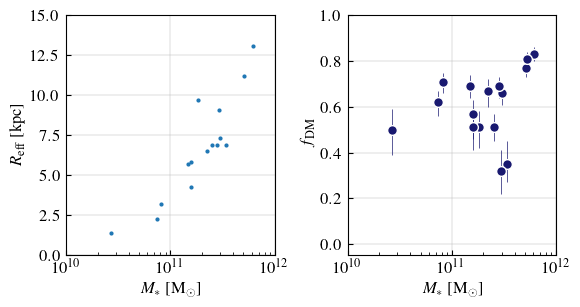

In [11]:
#################
# Plot parameters
params = {
    "font.size": 12,
    "font.family": "Times",
    "text.usetex": True,
    "figure.figsize": (7, 3),
    "figure.subplot.left": 0.25,
    "figure.subplot.right": 0.95,
    "figure.subplot.bottom": 0.15,
    "figure.subplot.top": 0.95,
    "figure.subplot.wspace": 0.35,
    "figure.subplot.hspace": 0.35,
    "lines.markersize": 2,
    "lines.linewidth": 1.5,
}
plt.rcParams.update(params)
plt.figure()
ax = plt.subplot(1, 2, 1)
plt.grid(linestyle='-', linewidth=0.3)

plt.plot(M, Reff, 'o')

plt.axis([1e10, 1e12, 0, 15])
plt.xscale('log')
plt.ylabel(r"$R_{\mathrm{eff}}$ [kpc]")
plt.xlabel("$M_{*}$ [M$_{\odot}$]")
ax.tick_params(direction='in', axis='both', which='both', pad=4.5)

######
ax = plt.subplot(1, 2, 2)
plt.grid(linestyle='-', linewidth=0.3)

plt.errorbar(M, fDM, yerr=error, marker='o', markersize=7, markeredgecolor="white", 
             ls='none', lw=0.5, c='midnightblue')

plt.axis([1e10, 1e12, -0.05, 1])
plt.xscale('log')
plt.ylabel(r"$f_{\mathrm{DM}}$")
plt.xlabel("$M_{*}$ [M$_{\odot}$]")
ax.tick_params(direction='in', axis='both', which='both', pad=4.5)
plt.show()

### Making the final csv file

In [ ]:
# Writing the data into a CSV file
with open('dataset/BARNABE11.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Writing the name line and the unit line
    writer.writerow([ "Name","Mstellar[Msun]","fDM(Reff)", "+ErrorfDM", "-ErrorfDM", "Reff[kpc]"])

    # Looping through each element of the data
    for i in range(len(M)):
        Name = GalaxyNames[i]
        Mass = M[i]
        fDMeff = fDM[i]
        psigma_fdmeff = higherror[i]
        msigma_fdmeff = lowerror[i]
        R = Reff[i]
        # Writing the data into the CSV file
        writer.writerow([ Name, Mass, fDMeff, psigma_fdmeff, msigma_fdmeff, R])
        

In [ ]:
# Reading the CSV file into a DataFrame
barnabe = pd.read_csv('dataset/BARNABE11.csv')
barnabe